In [1]:
import wandb
api = wandb.Api()
project = 'iit'
group = 'eval'
runs = api.runs(f'{project}', filters={"group": group, "state": "finished"})
print(runs)

<Runs cybershiptrooper/iit>


In [ ]:
import os
os.rmdir('results')

In [2]:
from tqdm import tqdm

files_to_download = ['results.csv', 'metric_collection.log', 'train_args.log', 'results_kl_div.csv', 'results_accuracy.csv']
print("Downloading files for runs")
import concurrent.futures

def download_files(run):
    for file in run.files():
        if any([file.name.endswith(ftd) for ftd in files_to_download]):
            file.download(replace=True)

# Create a ThreadPoolExecutor
with concurrent.futures.ThreadPoolExecutor() as executor:
    list(tqdm(executor.map(download_files, runs), total=len(runs)))

100%|██████████| 19/19 [00:14<00:00,  1.31it/s]


In [3]:
import dataframe_image as dfi

def make_image(results_dict, folder, run, kl_div=False):
    # remove unnamed columns from results
    images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
    if make_image and not os.path.exists(images_path):
        dfi.export(results_dict[run], images_path)

In [4]:
import pandas as pd

def walk_wandb_dir_and_get_results(weight: float = 510, make_image: bool = True):
    def drop_bad_columns_and_make_image(df, folder, kl_div=False):
        df.drop(columns=[c for c in df.columns if 'Unnamed' in c], inplace=True)
        if make_image:
            images_path = f"{folder}/results{'_kl_div' if kl_div else ''}.png"
            dfi.export(df, images_path)
        return df
    
    results = {}
    results_kl_div = {}
    for run in os.listdir('./results/ll_models/'):
        folder = os.path.join('./results/ll_models/', run, f'results_{weight}')
        result = os.path.join(folder, 'results.csv')
        result_accuracy = os.path.join(folder, 'results_accuracy.csv')
        result_kl_div = os.path.join(folder, 'results_kl_div.csv')
        if os.path.exists(result):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result), folder, kl_div=False)
        elif os.path.exists(result_accuracy):
            results[run] = drop_bad_columns_and_make_image(pd.read_csv(result_accuracy), folder, kl_div=False)
        if os.path.exists(result_kl_div):
            results_kl_div[run] = drop_bad_columns_and_make_image(pd.read_csv(result_kl_div), folder, kl_div=True)
    return results, results_kl_div

In [5]:
results, results_kl = walk_wandb_dir_and_get_results()
results_tracr, results_kl_tracr = walk_wandb_dir_and_get_results(weight="tracr", make_image=False)

In [6]:
from circuits_benchmark.utils.get_cases import get_cases
from circuits_benchmark.utils.iit.correspondence import TracrCorrespondence 
import iit.model_pairs as mp

def remove_nodes_with_zero_effect(df_iit, df_tracr):
    unique_runs = df_tracr['run'].unique()
    unique_runs = [int(run) for run in unique_runs]
    all_cases = get_cases(indices=unique_runs)
                          
    # iterate through rows where status = "in_circuit"
    for row in df_tracr[df_tracr['status'] == 'in_circuit'].index:
        effect = df_iit.loc[row, 'resample_ablate_effect']
        run = df_iit.loc[row, 'run']
        if effect == 0:
            print(f"Run {run} has node {df_tracr.loc[row, 'node_name']} with zero effect")
            # df_tracr.loc[row, 'status'] = 'not_in_circuit'
            node_name = df_tracr.loc[row, 'node_name']
            # get the case
            case = all_cases[unique_runs.index(run)]
            tracr_output = case.get_tracr_output()
            hl_ll_corr = TracrCorrespondence.from_output(tracr_output)
            if "mlp" in node_name:
                iit_node = hl_ll_corr[mp.HLNode(node_name)]
            elif "attn" in node_name:
                hook_name, head_num = node_name.split(', head ')
                iit_node = hl_ll_corr[mp.HLNode(hook_name, head_num)]
            else:
                raise ValueError(f"Node name {node_name} not recognized")
            print(f"Removing node {iit_node} from IIT circuit")
df_combined = pd.concat([df.assign(run=run) for run, df in results.items()])
df_combined_tracr = pd.concat(
        [df.assign(run=run) for run, df in results_tracr.items()]
    )
remove_nodes_with_zero_effect(df_combined, df_combined_tracr)

In [7]:
def get_circuit_lists(results, results_tracr, key, normalize_by_runs):
    results_cp = results.copy()
    results_cp_tracr = results_tracr.copy()
    for _, df in results_cp.items():
        if normalize_by_runs:
        # normalize the values of the key column by the maximum value in the column
            df[key] = df[key] / df[key].max()

    # combine dataframes for each run, and add a column for the run name
    df_combined = pd.concat([df.assign(run=run) for run, df in results_cp.items()])
    df_combined_tracr = pd.concat(
        [df.assign(run=run) for run, df in results_cp_tracr.items()]
    )

    def get_group(groups, key, run):
        try:
            return groups.get_group(key)
        except KeyError:
            # print run that does not have the key
            print(f"Run {run} does not have {key}")
            return pd.DataFrame()

    get_status = lambda df, status: {
        run: get_group(run_df.groupby("status"), status, run)
        for run, run_df in df.groupby("run")
    }

    in_circuit_list = get_status(df_combined, "in_circuit")
    not_in_circuit_list = get_status(df_combined, "not_in_circuit")
    tracr_in_circuit_list = get_status(df_combined_tracr, "in_circuit")
    tracr_not_in_circuit_list = get_status(df_combined_tracr, "not_in_circuit")

    # get common runs between tracr and non-tracr
    common_runs = set(in_circuit_list.keys()).intersection(
        set(tracr_in_circuit_list.keys())
    )
    in_circuit_list = [in_circuit_list[run] for run in common_runs]
    not_in_circuit_list = [not_in_circuit_list[run] for run in common_runs]
    tracr_in_circuit_list = [tracr_in_circuit_list[run] for run in common_runs]
    tracr_not_in_circuit_list = [
        tracr_not_in_circuit_list[run] for run in common_runs
    ]
    num_columnns = len(in_circuit_list)
    return (
        in_circuit_list,
        not_in_circuit_list,
        tracr_in_circuit_list,
        tracr_not_in_circuit_list,
        common_runs,
        num_columnns,
    )

In [8]:
results_tracr.keys(), results.keys()

(dict_keys(['27', '1', '8', '21', '24', '4', '3']),
 dict_keys(['32', '21', '24', '4', '3']))

In [9]:
import matplotlib.pyplot as plt

# make all font sizes bigger
plt.rcParams.update({"font.size": 13})


In [10]:
def plot_results_in_box_plot(
    results,
    results_tracr,
    key="resample_ablate_effect",
    normalize_by_runs=True,
    figsize=(10, 5),
):
    def plot_box(status_list, num_columnns, c, tracr=False):
        def get_key(df):
            try:
                return df[key]
            except KeyError:
                return pd.Series()

        plt.boxplot(
            [get_key(df) for df in status_list],
            positions=range(1 * tracr, num_columnns * 2, 2),
            patch_artist=True,
            showfliers=False,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
        )

    (
        in_circuit_list,
        not_in_circuit_list,
        tracr_in_circuit_list,
        tracr_not_in_circuit_list,
        common_runs,
        num_columnns,
    ) = get_circuit_lists(results, results_tracr, key, normalize_by_runs)
    plt.figure(figsize=figsize)
    plt.title(f"{key} for different runs")
    plot_box(in_circuit_list, num_columnns, "darkcyan")
    plot_box(tracr_in_circuit_list, num_columnns, "darkcyan", tracr=True)
    plot_box(not_in_circuit_list, num_columnns, "orangered")
    plot_box(tracr_not_in_circuit_list, num_columnns, "orangered", tracr=True)

    x_tick_labels = []
    for i, run in enumerate(common_runs):
        x_tick_labels.append(run)
        x_tick_labels.append(run + "_tracr")

    plt.xticks(
        range(0, num_columnns * 2),
        x_tick_labels,
    )

Run 1 does not have not_in_circuit
Run 8 does not have not_in_circuit


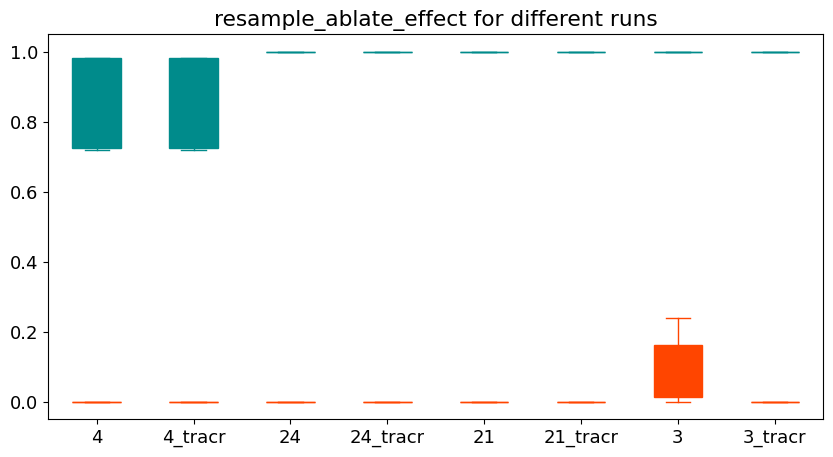

In [11]:
plot_results_in_box_plot(results, results_tracr,
             key = "resample_ablate_effect",
             normalize_by_runs=False)

Run 1 does not have not_in_circuit
Run 32 does not have not_in_circuit


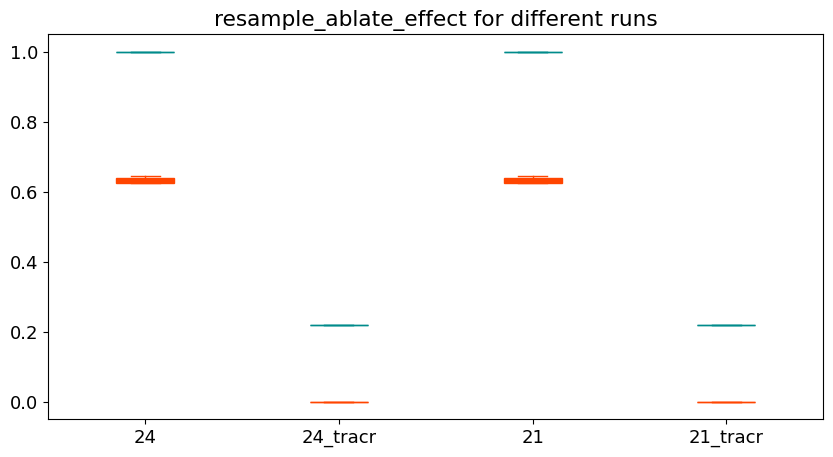

In [16]:
plot_results_in_box_plot(results_kl, results_kl_tracr,
             key = "resample_ablate_effect",
             normalize_by_runs=True)

In [ ]:
def plot_results_in_scatter_plot(
    results,
    results_tracr,
    key="resample_ablate_effect",
    normalize_by_runs=True,
    figsize=(10, 5),
    plot_minmax_lines=True,
):
    (
        in_circuit_list,
        not_in_circuit_list,
        tracr_in_circuit_list,
        tracr_not_in_circuit_list,
        _,
        _,
    ) = get_circuit_lists(results, results_tracr, key, normalize_by_runs)
    def get_key(df):
        try:
            return df[key]
        except KeyError:
            return pd.Series()
    iit_in_circuit_effect_list = [get_key(df).mean() for df in in_circuit_list]
    iit_not_in_circuit_effect_list = [get_key(df).mean() for df in not_in_circuit_list]
    tracr_in_circuit_effect_list = [get_key(df).mean() for df in tracr_in_circuit_list]
    tracr_not_in_circuit_effect_list = [get_key(df).mean() for df in tracr_not_in_circuit_list]

    plt.figure(figsize=figsize)
    plt.title(f"Comparing {key} for different runs")
    plt.scatter(
        tracr_in_circuit_effect_list,
        iit_in_circuit_effect_list,
        color="darkcyan",
        label="iit_in_circuit",
        alpha=0.4,
        s=150,
    )
    print(len(tracr_not_in_circuit_effect_list), len(iit_not_in_circuit_effect_list))
    plt.scatter(
        tracr_not_in_circuit_effect_list,
        iit_not_in_circuit_effect_list,
        color="orangered",
        label="iit_not_in_circuit",
        alpha=0.4,
        s=150,
    )
    plt.plot([0, 1], [0, 1], color="black", linestyle="--", alpha=0.9)
    plt.xlabel("tracr ablate effect")
    plt.ylabel("iit ablate effect")
    legend_list = [
        "in_circuit",
        "not_in_circuit",
        "x=y line"
    ]
    if plot_minmax_lines:
        plt.hlines(
            [min(iit_in_circuit_effect_list)],
            0, 1,
            color="darkcyan",
            linestyle="--",
        )
        plt.hlines(
            [max(iit_not_in_circuit_effect_list)],
            0, 1,
            color="maroon",
            linestyle="--",
        )
        # plot the gap
        gap_color = "green" if min(iit_in_circuit_effect_list) > max(iit_not_in_circuit_effect_list) else "red"
        plt.plot(
            [0.5, 0.5],
            [min(iit_in_circuit_effect_list), max(iit_not_in_circuit_effect_list)],
            color=gap_color,
            linestyle="--",
        )
        # fill the gap with color
        plt.fill_between(
            [0, 1],
            min(iit_in_circuit_effect_list),
            max(iit_not_in_circuit_effect_list),
            color=gap_color,
            alpha=0.2,
        )

        legend_list += ["min_in_circuit", "max_not_in_circuit", "gap"]

    plt.legend(legend_list, loc='center left', bbox_to_anchor=(1, 0.7))


Run 1 does not have not_in_circuit
Run 8 does not have not_in_circuit
4 4


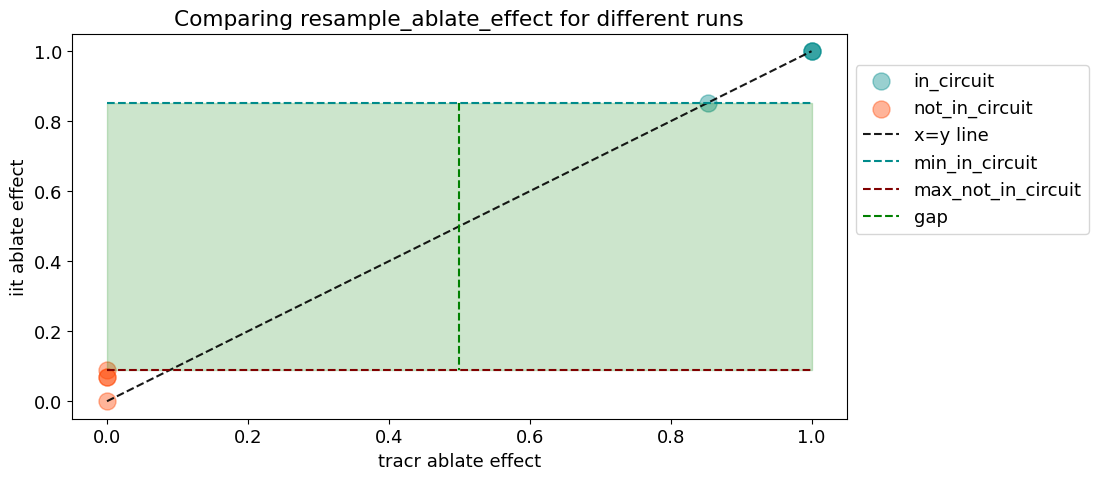

In [ ]:
plot_results_in_scatter_plot(results, results_tracr,
                key = "resample_ablate_effect",
                normalize_by_runs=False,
                plot_minmax_lines=True)

Run 1 does not have not_in_circuit
Run 32 does not have not_in_circuit
2 2


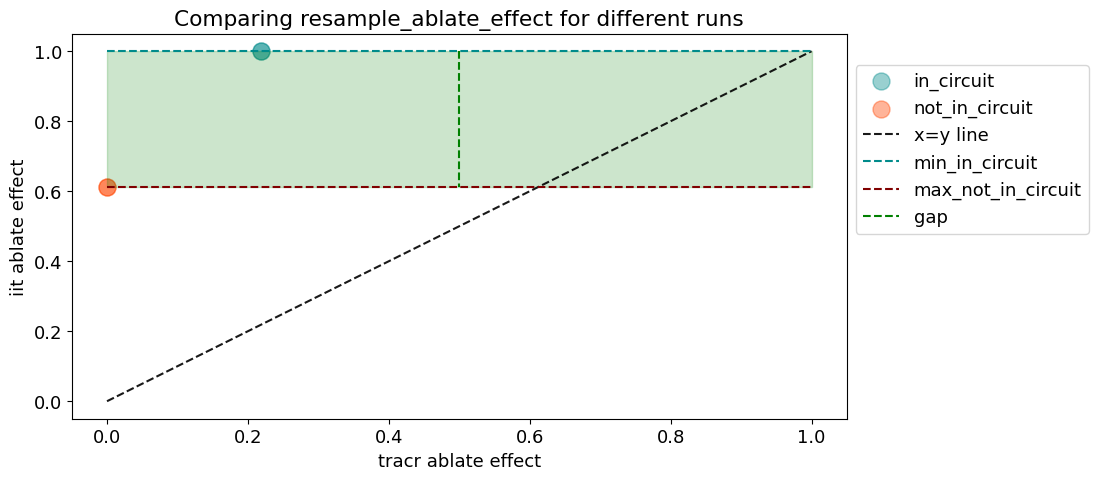

In [ ]:
plot_results_in_scatter_plot(results_kl, results_kl_tracr,
                key = "resample_ablate_effect",
                normalize_by_runs=True,
                plot_minmax_lines=True)

In [ ]:
(
        in_circuit_list,
        not_in_circuit_list,
        tracr_in_circuit_list,
        tracr_not_in_circuit_list,
        _,
        _,
    ) = get_circuit_lists(results, results_tracr, 'resample_ablate_effect', True)

Run 1 does not have not_in_circuit
Run 8 does not have not_in_circuit


In [ ]:
[list(li['resample_ablate_effect']) for li in in_circuit_list]
[list(li['resample_ablate_effect']) for li in not_in_circuit_list]

[[0.06083371813924547,
  0.06170775669278121,
  0.06471835338402994,
  0.055485085967888544,
  0.054035228995786194,
  0.054547129372050834,
  0.05463707894403212,
  0.057171456239202015],
 [4.388077286678218e-05,
  3.9096960942954264e-05,
  4.3609808424576456e-05,
  0.5498636249317593,
  0.00011739348630971736,
  3.5604699638985926e-05,
  3.359944280807698e-05,
  4.194820062992783e-05,
  0.15811903830869298],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [4.388077286678218e-05,
  3.9096960942954264e-05,
  4.3609808424576456e-05,
  0.5498636249317593,
  0.00011739348630971736,
  3.5604699638985926e-05,
  3.359944280807698e-05,
  4.194820062992783e-05,
  0.15811903830869298],
 [0.11703515098921266,
  0.027674062365405015,
  0.04070652730425542,
  0.20460492452954118,
  0.0002829709406696001,
  0.0,
  0.24021232431255102],
 [0.12239016604355321,
  0.012463472646729217,
  0.13853017838068601,
  0.007284367934942995,
  0.007254498445042449,
  0.007053694706982794,
  0.00739251412787668,
  0.0136896837